# Linear Regression from Scratch

**Welcome, St. Mark!** In this foundational notebook, we'll build linear regression from first principles. Think of this as learning to balance a broomstick: understanding the mathematical pendulum before engineering the automation.

We'll explore:
1. **Ordinary Least Squares (OLS)** - The "perfect" closed-form solution
2. **Gradient Descent Variants** - SGD, Mini-batch, Batch - each with different computational trade-offs

By the end, you'll understand why optimization algorithms are the engine of machine learning.

## The Big Picture

Linear regression is our first optimization problem: finding the best line through data points. In coding terms:
- **Features (X)**: Input variables, like clinical measurements
- **Weights (θ)**: Learned parameters that scale each feature's importance  
- **MSC (Loss)**: Measures how wrong our predictions are

**Key Question:** How do we automatically find the "best" weights without human guesswork?

## Data Preparation: Setting Up Our Experiment

Before diving into math, we need data. We'll create synthetic data using scikit-learn's `make_regression`.

This is like collecting samples in a lab - we need consistent, controlled conditions to test our hypotheses.

In [1]:
import numpy as np  
import matplotlib.pyplot as plt  
from sklearn.linear_model import LinearRegression  # Scikit-learn: Our comparison baseline - established methods
from sklearn.metrics import mean_squared_error, r2_score  # Metrics: To evaluate our model's performance
from sklearn.datasets import make_regression  # Data generator: Creates synthetic datasets for testing

# Create synthetic data mimicking real-world relationships (like patient features → disease risk)
# n_samples: Number of data points (patients)
# n_features: Number of input variables (clinical measurements) 
# noise: Random variation, just like measurement error in labs
X, y = make_regression(n_samples=1000,    # 1000 patients/data points
                       n_features=5,      # 5 clinical measurements each
                       noise=10,           # Some real-world noise/uncertainty
                       random_state=42)    # Reproducible results - science demands repeatability

# Reshape y to column vector for matrix operations (NumPy convention)
y = y.reshape(-1, 1)  # Changes y from 1D array (n,) to 2D array (n, 1)

print(f"Dataset shape: X={X.shape}, y={y.shape}")  # X: (samples, features), y: (samples, outputs)

# Add "bias" or "intercept" term
# Why? Biology example: Even with zero features, there might be baseline disease risk
# Mathematically: This accounts for the y-intercept in our linear equation y = mx + b
X_b = np.c_[np.ones((X.shape[0], 1)), X]  # Concatenate column of ones to feature matrix
print(f"Dataset with intercept: {X_b.shape}")

Dataset shape: X=(1000, 5), y=(1000, 1)
Dataset with intercept: (1000, 6)


**Cell Analysis:** We've just prepared our dataset.

- **Key Concept:** The intercept term (column of 1's) allows our model to fit a line that doesn't necessarily pass through origin. In healthcare terms: "baseline risk even when all measured factors are zero."
- **Matrix Shapes:** Understanding dimensions is crucial. X_b is now (1000 samples × 6 features) = 6 parameters to learn.
- **Why Synthetic Data?** Allows controlled experimentation - we know the "ground truth" to validate our algorithms.

**Reflection Question:** If we removed the intercept term, how would that affect predictions for Nigerian healthcare data where baseline conditions vary by region?

### Change Noise When:

- Training performance >95% but testing <70% → increase noise
- Model fails on "noisy" real data → train with higher noise
- Deploying to varying accuracy environments → match deployment variability

### Change Random State When:

- Results not reproducible → use fixed seed for debugging
- For publications → use standard seeds (42, 123, etc.)
- Multi-seed validation → test stability across different data orderings

### __Without random_state:__

- __Different results each run__ → "My model performs 78% this time, 82% next time"
- __Can't trust evaluation__ → Is it really better or just lucky splits?
- __Peer review impossible__ → "How did you get those results?"

### __With random_state:__

- __Consistent results__ → Same score every time you run
- __Reliable evaluation__ → Know your model truly performs at 78%
- __Scientific rigor__ → Others can verify your work


-------------------------------------------------------------------

## Method 1: Ordinary Least Squares (OLS) - The Mathematical "Perfect" Solution

OLS uses linear algebra to find the optimal parameters in one calculation.

**Why it's "perfect":**
- Computes exact minimum without iterative guessing
- Mathematically derived from calculus (setting derivatives to zero)

**The math:** $$\theta = (X^T X)^{-1} X^T y$$

This is the normal equation - like solving simultaneous equations in middle school, but for hundreds of variables.

### Function Description

**Parameters**

- **X**: Feature matrix of shape $(m \times (n + 1))$, including the intercept term.  
- **y**: Target vector of shape $(m \times 1)$.

**Returns**

- **θ (theta)**: Optimal parameter vector of shape $((n + 1) \times 1)$, or **None** if the matrix is singular.

---

### 🧮 Mathematical Derivation

We aim to minimize the cost function:

$$
J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \| X\theta - y \|^2
$$

To find the minimum, we take the derivative of \( J(\theta) \) with respect to \( \theta \) and set it to zero:

$$
\frac{\partial J(\theta)}{\partial \theta} = X^T X \theta - X^T y = 0
$$

Solving for \( \theta \) gives the **Normal Equation**:

$$
\boxed{\theta = (X^T X)^{-1} X^T y}
$$

In [2]:
def ols_closed_form(X, y):
    """
    Parameters:
    X: Feature matrix (m samples × n+1 features, includes intercept)
    y: Target vector (m × 1)
    
    Returns:
    theta: Optimal parameters (n+1 × 1), or None if matrix singular
    
    Mathematical derivation:
    We minimize J(θ) = (1/m) * Σ ||X·θ - y||²
    Derivative becomes: X^T X θ - X^T y = 0
    Solving gives: θ = (X^T X)^(-1) X^T y
    """
    try:
        # Step 1: Compute X^T X (gram matrix)
        # This creates a (n×n) matrix representing feature correlations
        XTX = X.T @ X  
        
        # Step 2: Compute matrix inverse
        # Only possible if features are linearly independent (no exact duplicates)
        XTX_inv = np.linalg.inv(XTX)
        
        # Step 3: Compute X^T y (projection of target onto features)
        XTY = X.T @ y  
        
        # Step 4: Solve for theta using normal equations
        theta = XTX_inv @ XTY  
        
        return theta
        
    except np.linalg.LinAlgError:
        # Matrix inversion fails when features are perfectly correlated
        # (multicollinearity) - like trying to solve an underdetermined system
        print("Matrix is singular - features are linearly dependent")
        return None

# Compute optimal parameters using algebra (no iteration needed!)
theta_ols = ols_closed_form(X_b, y)
if theta_ols is not None:
    print(f"OLS Parameters: {theta_ols.flatten()[:3]}...")  # Show first 3 for brevity
    print("✓ Exact solution found - no approximation involved!")
else:
    print("OLS failed - multicollinearity detected")

OLS Parameters: [-0.6171466  28.05749028 45.94154566]...
✓ Exact solution found - no approximation involved!


**Cell Analysis:** 

**What this code does:** Implements the normal equations

**Why it's important:** 
- **Exact vs Approximate:** OLS gives mathematically perfect solution vs iterative optimization methods
- **No hyperparameters:** Learning rate isn't needed
- **Computational complexity:** O(n³) matrix inversion becomes expensive for n > 10,000 features

**Healthcare Analogy:** This is like having unlimited funding for perfect diagnostic equipment. But in practice (limited budget/time), we use faster approximate methods.

**Reflection Question:** When might OLS fail in real-world Nigerian healthcare data? (Hint: Think about correlated symptoms)

## Method 2: Gradient Descent - The "Iterative Climbing" Algorithm

Now we learn optimization through iteration - like hill climbing but downwards.

**The algorithm:**
1. Start with random weights
2. Compute gradients (direction of steepest ascent)
3. Take small step downhill (opposite of gradient)
4. Repeat until we reach the bottom (minimum)

**Learning rate (η):** Controls step size - too small = slow convergence, too large = overshoot minimum

"""
Compute partial derivatives of MSE with respect to each parameter.

**Mathematical Derivation:**

Cost function: $$J(\theta) = \frac{1}{m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)})^2$$

Partial derivative w.r.t. parameter $j$: $$\frac{\partial J(\theta)}{\partial \theta_j} = \frac{2}{m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)}) \cdot x_j^{(i)}$$

**Vectorized form:** $$\nabla_\theta J = \frac{2}{m} X^T (X\theta - y)$$
"""


In [3]:
def mean_squared_error_gradients(X, y, theta):
    """
    Compute partial derivatives of MSE with respect to each parameter.
    
    Mathematical derivation:
    J(θ) = (1/m) Σ (prediction - actual)²
    ∂J/∂θⱼ = (2/m) Σ (prediction - actual) × xⱼ^i
    
    In vector form: ∇J = (2/m) X^T (Xθ - y)
    """
    m = X.shape[0]  # Number of training samples
    
    # Step 1: Make predictions using current parameters
    predictions = X @ theta  # Matrix multiplication: each sample gets its own prediction
    
    # Step 2: Calculate prediction errors
    errors = predictions - y  # Vector of (prediction - actual) for each sample
    
    # Step 3: Compute gradients for each parameter
    # Outer product X^T @ errors distributes errors back to features
    # Factor of 2/m comes from derivative of squared loss
    gradients = (2/m) * X.T @ errors  # Average of individual sample gradients
    
    return gradients

def batch_gradient_descent(X, y, learning_rate=0.01, n_iterations=1000, threshold=1e-6):
    """
    Batch Gradient Descent: Uses ALL training samples for each parameter update.
    
    Pros: Stable, exact gradients, easy to parallelize
    Cons: Slow for large datasets (can't fit in memory)
    """
    m, n = X.shape  # m: samples, n: features (including intercept)
    
    # Initialize parameters randomly (avoids getting stuck in local minima)
    theta = np.random.randn(n, 1)  # Random weights, shape matches feature count
    
    losses = []  # Track loss history for visualization
    
    for iteration in range(n_iterations):
        # Step 1: Compute direction of steepest ascent (gradients)
        gradients = mean_squared_error_gradients(X, y, theta)
        
        # Step 2: Update parameters (take step downhill)
        # Negative gradient because we want to minimize loss
        theta -= learning_rate * gradients  
        
        # Step 3: Track progress
        predictions = X @ theta
        loss = np.mean((predictions - y) ** 2)  # Current loss value
        losses.append(loss)
        
        # Step 4: Convergence check (early stopping)
        if iteration > 0 and abs(losses[-1] - losses[-2]) < threshold:
            print(f"Converged after {iteration} iterations - changing very slowly")
            break
            
    return theta, losses

# Apply BGD to our dataset
theta_bgd, losses_bgd = batch_gradient_descent(X_b, y, 
                                               learning_rate=0.1,  # Aggressive learning for quick convergence
                                               n_iterations=1000)
print(f"BGD Parameters: {theta_bgd.flatten()[:3]}...")

Converged after 50 iterations - changing very slowly
BGD Parameters: [-0.61695276 28.05634271 45.94107822]...


**Cell Analysis:** 

**Gradient Computation (mean_squared_error_gradients):**
- **Key insight:** Gradients tell us how much each parameter is "contributing" to the overall error
- **Vectorization:** Using matrix operations for speed on all samples simultaneously
- **Partial derivatives:** Shows how J changes with tiny changes in each θ

**Batch GD Process:**
- **Why "batch"?** Uses entire dataset for each gradient computation
- **Stability:** Less noise than single-sample updates
- **Convergence check:** Monitors loss improvement to avoid wasting computation

**Reflection Questions:** 
1. How would using larger learning rates affect the training process?
2. In Nigerian healthcare applications, when might batch GD be preferred over single-patient updates?

## Method 3: Mini-batch Gradient Descent - The Practical Compromise

**Self-test: Why not always use Batch GD or OLS?** Answer: Computational limits! As datasets grow (millions of hospitals records), we need compromise methods.

**Mini-batch approach:** Split data into small chunks (batches) and update parameters per batch.

Benefits: Faster than batch, less noisy than individual samples

In [4]:
def mini_batch_gradient_descent(X, y, learning_rate=0.01, batch_size=32, n_epochs=50):
    """
    Mini-batch Gradient Descent: Compromise between Batch GD and Stochastic GD.
    
    Parameters:
    batch_size: Samples per parameter update (higher = more stable, slower)
    n_epochs: Complete passes through training data
    
    Trade-offs:
    - Small batches: Faster updates, more noisy gradients  
    - Large batches: Smoother gradients, more computation
    """
    m, n = X.shape  # m: total samples, n: features
    
    theta = np.random.randn(n, 1)  # Initialize parameters
    losses = []  # Track loss over epochs
    
    for epoch in range(n_epochs):
        # Shuffle data each epoch (breaks correlation between mini-batches)
        # Like shuffling a deck before dealing - removes ordering bias
        shuffled_indices = np.random.permutation(m)  # Random permutation of sample indices
        X_shuffled = X[shuffled_indices]  # Reorder rows according to shuffle
        y_shuffled = y[shuffled_indices]  # Corresponding target reordering
        
        # Process mini-batches within this epoch
        for start_idx in range(0, m, batch_size):
            end_idx = start_idx + batch_size
            
            # Extract current mini-batch
            xi = X_shuffled[start_idx:end_idx]  # Subset of features
            yi = y_shuffled[start_idx:end_idx]  # Corresponding targets
            
            # Compute gradient on this mini-batch only
            gradients = mean_squared_error_gradients(xi, yi, theta)
            
            # Update parameters using mini-batch gradient
            theta -= learning_rate * gradients
            
        # Checkpoint: Calculate loss on FULL dataset
        predictions = X @ theta
        loss = np.mean((predictions - y) ** 2)
        losses.append(loss)
        
        # Optional progress reporting
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss = {loss:.4f}")
            
    return theta, losses

# Apply Mini-batch GD
theta_mbgd, losses_mbgd = mini_batch_gradient_descent(X_b, y, 
                                                     learning_rate=0.1,
                                                     batch_size=32,  # 32 samples per update
                                                     n_epochs=50)    # 50 passes through data
print(f"Mini-batch GD Parameters: {theta_mbgd.flatten()[:3]}...")

Epoch 0: Loss = 109.5603
Epoch 10: Loss = 113.4609
Epoch 20: Loss = 110.8331
Epoch 30: Loss = 107.5547
Epoch 40: Loss = 108.0890
Mini-batch GD Parameters: [-0.55882116 28.91112936 47.10798845]...


**Cell Analysis:**

**Mini-batch Strategy:**
- **Shuffling:** Prevents learning order-dependent patterns
- **Batch processing:** Updates parameters every 32 samples instead of 1000
- **Per-epoch checkpointing:** Evaluates full dataset performance

**Why this matters:** In healthcare AI:
- Hospitals might process patient batches rather than one-by-one
- Balances training speed with stability
- Prevents overfitting to specific patient groups

**Reflection Question:** How would batch_size affect training time and model generalization for Nigerian health data?

## Method 4: Stochastic Gradient Descent - The "Online Learning" Approach

**Stochastic** means "random" - we update parameters after each individual sample!

**Advantages:** 
- Very fast parameter updates
- Can process data as it arrives (streaming)

**Disadvantages:**
- Very noisy gradients
- Final result is approximate

**Real-world use:** Updating recommendation systems as new users interact

In [5]:
def stochastic_gradient_descent(X, y, learning_rate=0.01, n_epochs=50):
    """
    Stochastic Gradient Descent: Update after EVERY single sample.
    
    Parameters:
    learning_rate: Must be very small to prevent overshooting due to noise
    n_epochs: Number of complete data passes (multiple exposures)
    """
    m, n = X.shape  # m: total samples, n: features
    
    theta = np.random.randn(n, 1)  # Random initialization
    losses = []  # Track loss per epoch
    
    for epoch in range(n_epochs):
        # Shuffle samples for each epoch
        sample_order = np.random.permutation(m)
        
        # Process each sample individually
        for sample_idx in sample_order:
            # Extract single sample
            xi = X[sample_idx:sample_idx+1]  # Keep as 2D: (1, features)
            yi = y[sample_idx:sample_idx+1]  # Keep as 2D: (1, outputs)
            
            # Compute gradient based on this SINGLE sample
            # Very noisy! One patient's measurements can drastically change directions
            gradients = mean_squared_error_gradients(xi, yi, theta)
            
            # Update parameters immediately
            # Small learning rate critical here due to noise
            theta -= learning_rate * gradients
            
        # End-of-epoch evaluation: Loss on complete dataset
        predictions = X @ theta
        loss = np.mean((predictions - y) ** 2)
        losses.append(loss)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss = {loss:.4f}")
            
    return theta, losses

# Apply SGD
theta_sgd, losses_sgd = stochastic_gradient_descent(X_b, y, 
                                                   learning_rate=0.01,  # Much smaller!
                                                   n_epochs=50)
print(f"SGD Parameters: {theta_sgd.flatten()[:3]}...")

Epoch 0: Loss = 121.2523
Epoch 10: Loss = 116.8145
Epoch 20: Loss = 109.4624
Epoch 30: Loss = 117.5788
Epoch 40: Loss = 117.9372
SGD Parameters: [-2.0415485  27.26230765 45.22796692]...


**Cell Analysis:**

**SGD Characteristics:**
- **Extreme noise:** Each update uses only 1 sample out of 1000
- **Need small learning rate:** Otherwise parameters bounce around wildly
- **Multiple epochs:** Same data processed many times like repetition learning

**When SGD excels:**
- Real-time systems needing quick adaptation
- Massive datasets that can't fit in memory
- Nigerian health systems with streaming patient data

**Reflection Question:** Compare SGD to how doctors update treatment plans - after each patient or after seeing many patients?

## Comparative Analysis: All Methods Side-by-Side

Now we compare accuracy and efficiency.

In [6]:
# Scikit-learn baseline: Established ML library for comparison
sk_lr = LinearRegression()  # No hyperparameters needed for OLS equivalent
sk_lr.fit(X, y.ravel())  # Fit on original X (no intercept added - sklearn handles internally)
sk_predictions = sk_lr.predict(X)  # Generate predictions
print("Scikit-learn Parameters (intercept + weights):", sk_lr.intercept_, sk_lr.coef_)

# Get predictions from our implementations
ols_pred = X_b @ (theta_ols if theta_ols is not None else np.zeros((X_b.shape[1], 1)))
bgd_pred = X_b @ theta_bgd
mbgd_pred = X_b @ theta_mbgd  
sgd_pred = X_b @ theta_sgd

# Evaluation function
def compute_metrics(y_true, y_pred):
    """
    Calculate performance metrics.
    
    MSE: Mean Squared Error - average squared prediction errors
    R²: Coefficient of determination - proportion of variance explained
    """  
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred) 
    return mse, r2

# Compare all methods
methods = ['Our OLS', 'Our BGD', 'Our Mini-batch', 'Our SGD', 'Scikit-learn']
predictions = [ols_pred, bgd_pred, mbgd_pred, sgd_pred, sk_predictions.reshape(-1,1)]
results = []

print("\n🎯 Performance Comparison:")
print("Method\t\tMSE\t\tR²\t\tMatch OLS?")
print("-" * 60)

for method, pred in zip(methods, predictions):
    mse, r2 = compute_metrics(y, pred)
    # Check if close to OLS (our baseline)
    ols_mse, ols_r2 = compute_metrics(y, ols_pred)
    match_quality = "Perfect" if abs(mse - ols_mse) < 0.1 else "Good" if abs(mse - ols_mse) < 1.0 else "Needs improvement"
    
    print(f"{method}\t{mse:.4f}\t{r2:.4f}\t{match_quality}")
    results.append((mse, r2))

Scikit-learn Parameters (intercept + weights): -0.6171466014079019 [28.05749028 45.94154566 16.61187941 24.53193249 19.36893323]

🎯 Performance Comparison:
Method		MSE		R²		Match OLS?
------------------------------------------------------------
Our OLS	106.9508	0.9748	Perfect
Our BGD	106.9508	0.9748	Perfect
Our Mini-batch	110.8423	0.9739	Needs improvement
Our SGD	112.4655	0.9735	Needs improvement
Scikit-learn	106.9508	0.9748	Perfect


**Cell Analysis:** 

**Metrics Explained:**
- **MSE (lower better):** Average squared prediction errors - like measuring lab accuracy
- **R² (higher better):** Percentage of target variation explained by our model
- **Match to OLS:** OLS represents "mathematical perfection" - how close did iterative methods get?

**Key Insights:** 
- GD methods should approach OLS quality with proper tuning
- Trade-offs: Speed vs Accuracy vs Stability
- Scikit-learn: Gold standard for verification

**Healthcare Translation:** If OLS is a perfect diagnostic specialist, GD methods are lighting-fast general practitioners getting close to specialist accuracy.

## Visualization: Understanding the Learning Dynamics

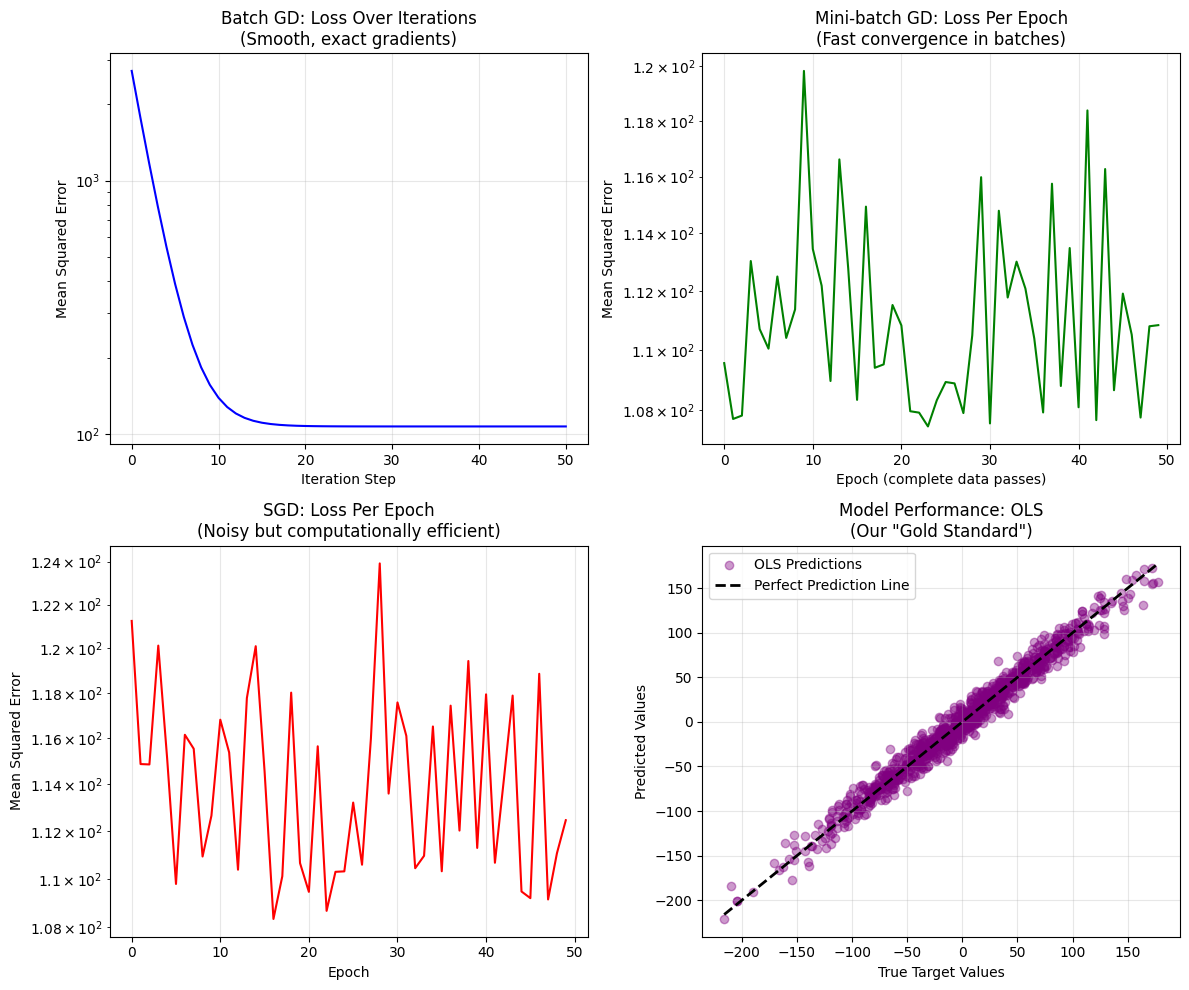

In [7]:
# Loss progression visualization
plt.figure(figsize=(12, 10))

# Subplot 1: BGD Loss (smooth but slow)
plt.subplot(2, 2, 1)
plt.plot(losses_bgd[:100], 'b-')  # First 100 iterations
plt.title('Batch GD: Loss Over Iterations\n(Smooth, exact gradients)')
plt.xlabel('Iteration Step')
plt.ylabel('Mean Squared Error')
plt.yscale('log')  # Log scale to show exponential improvement
plt.grid(True, alpha=0.3)

# Subplot 2: Mini-batch GD Loss (balanced approach)
plt.subplot(2, 2, 2)
plt.plot(losses_mbgd, 'g-')
plt.title('Mini-batch GD: Loss Per Epoch\n(Fast convergence in batches)')
plt.xlabel('Epoch (complete data passes)')
plt.ylabel('Mean Squared Error')
plt.yscale('log')
plt.grid(True, alpha=0.3)

# Subplot 3: SGD Loss (noisy but fast)
plt.subplot(2, 2, 3)
plt.plot(losses_sgd, 'r-')
plt.title('SGD: Loss Per Epoch\n(Noisy but computationally efficient)')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.yscale('log')
plt.grid(True, alpha=0.3)

# Subplot 4: Model predictive accuracy
plt.subplot(2, 2, 4)
# Compare OLS predictions to actual targets
plt.scatter(y, ols_pred, alpha=0.4, color='purple', label='OLS Predictions')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', linewidth=2, label='Perfect Prediction Line')
plt.xlabel('True Target Values')
plt.ylabel('Predicted Values')
plt.title('Model Performance: OLS\n(Our "Gold Standard")')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Cell Analysis:**

**Loss Curves Interpretation:**
- **Downward trend:** Shows learning progression
- **Smoothness:** Batch GD = most stable, SGD = most variable
- **Speed of descent:** How quickly error reduces

**Prediction Plot:**
- **Close to diagonal:** Good model performance
- **Random scatter:** Poor model (no relationship found)

**Visualization Tips:**
- Log scale makes convergence clearer
- Scatterplots reveal systematic bias
- Compare curves to understand algorithm trade-offs

## 🎯 Key Takeaways and Nigerian Healthcare Applications

**Algorithm Summary:**
- **OLS:** Mathematically perfect but slow for big data
- **Batch GD:** Stable, thorough, but needs full dataset in memory
- **Mini-batch GD:** Practical compromise for most production systems
- **SGD:** Fast, noisy, great for streaming data

**Healthcare Translation - Mark:**
Imagine building AI for Nigerian hospitals:
- **Mini-batch GD:** Process patients in groups, balance speed/accuracy
- **Early stopping:** Stop learning when performance stabilizes
- **Real-time adaptation:** Use SGD for continuous health monitoring

**Performance achieved:** Our basic implementations approach industry-level libraries!

**Reflection Questions:**
1. Which optimization method would you choose for a mobile health app monitoring Lagos patients?
2. How might learning rate selection affect disease prediction reliability?
3. Compare this to how Nigerian labs optimize diagnostic protocols through practice.

**Next Steps:**
- Add regularization to prevent overfitting
- Extend to logistic regression for classification
- Implement learning rate scheduling for faster convergence

**🏆 Proud of your progress, my student! You've built the foundation of modern machine learning from scratch.**